# Exercises

---

## Exercise 1: structured and ustructured images
Write a function that outputs the number of PC you have to choose to retain a given percentage of explained variance.
Use this funtion on the  handwritten digit data, and plot the number of PC needed to retain a certain fraction of EVR, for a few vaules of EVR.

Compare this curve to the one you can obtain in unstructured images: either generate images with the same shape of our data or randomly permute the pixels in each image independenlty. How does the number of PC needed to retain a certain fraction of the variance in this case compare to the number needed for digit images?

In [3]:
import numpy as np
from scipy import io
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [4]:
def PC_number_for_ev_percentage(pca, desired_ev_percentage):
    n = 0
    ev_percentage = 0
    while ev_percentage < desired_ev_percentage:
        ev_percentage+=pca.explained_variance_ratio_[n]
        n+=1
    return n

In [5]:
dataset = load_digits()
images = dataset.data
scaler = StandardScaler()
X = scaler.fit_transform(images)
pca = PCA()
pca.fit(X)

random_X = scaler.fit_transform(np.random.rand(X.shape[0], X.shape[1]))
pca_random = PCA()
pca_random.fit(random_X)


PCA()

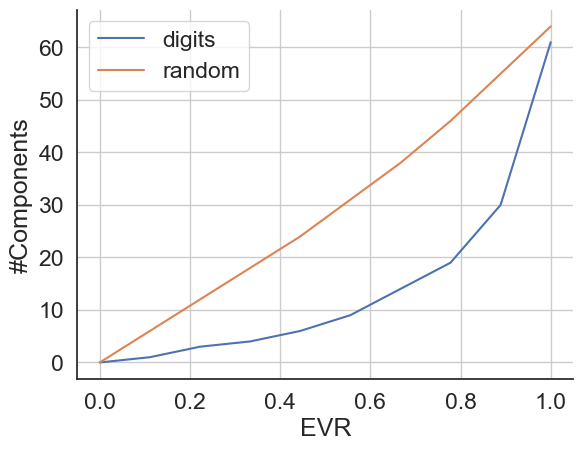

In [6]:
desired_EVRs = np.linspace(0,1, 10)
required_PCs = np.zeros((2,10))
for i,r in enumerate(desired_EVRs):
    required_PCs[:,i]= [PC_number_for_ev_percentage(pca, r), PC_number_for_ev_percentage(pca_random, r)]

plt.plot(desired_EVRs, required_PCs[0,:], label = "digits")
plt.plot(desired_EVRs, required_PCs[1,:], label = "random")
plt.legend()
plt.grid()
plt.xlabel("EVR")
plt.ylabel("#Components")
plt.show()

### Discussion

As to be expected, the low correlation in the random data, makes the number of components and the EVR nearly linear in dependence, while the digits have strongly correlated neihboring pixels and some pixels that are not used at all. 

## Exercise 2: cortical dynamics

Work with the cortical data we used in the lesson. Write some code that lets you easily chose a specific behavioural event from the `trial_data` dictionary (the recorded events are `CSp` for positive conditioned stimulus, `CSn` for negative conditioned stimulus and `licks` for lick events), one of the principal components, an onset time and and offset time, and plots the timecourse of this component in the selected period around the chosen event type.

Use this code to explore the data: how do different components behave? Do you notice any patterns? How would you test for the statistical significance of the effects that you see (if any)?

In [7]:
import pickle

with open('./data/behaviour.pickle', 'rb') as handle:
    trial_data = pickle.load(handle)

voltage_signal = np.load('./data/voltage_signal.npy')
cortex_mask = np.load('./data/cortex_mask.npy')

X = voltage_signal.transpose(2,0,1) # reshape in time x image format
T,h,w = X.shape # saves time, height and width for future use
X = X[:,cortex_mask] # select only cortex pixels, returns a flattened image
pca = PCA(n_components=50);
pca.fit(X)

from scipy.ndimage import gaussian_filter1d


from scipy.stats import sem

def plot_around_event(type, start_time = -1., end_time = 2., comp = 8):
    PCs = pca.components_[:10,:].T # select and transpose first 10 PCs weights
    Y = X @ PCs # compute the PC timecourse, by projecting the original data on each component

    framerate = 50. #in Hz

    frame_times = trial_data['frames'] #frame times

    peri_Y = [] #empty list for peri-lick timecourses

    #cycle over licking onsets
    for i in trial_data[type]:
        onset_frame = np.argmin(abs(frame_times-i)) #take frame closest to onset
        start_frame = int(onset_frame + framerate*start_time/1.000) # compute starting frame
        end_frame = int(onset_frame + framerate*end_time/1.000) # compute ending frame
        peri_Y.append(Y[start_frame:end_frame]) #saves the slice of Y

    peri_Y = np.asarray(peri_Y) 

    mean_Y = np.mean(peri_Y,axis=0) #average over licks
    error = sem(peri_Y,axis=0) #compute sem over licks

    plt.figure(figsize=(10,5))
    t = np.linspace(start_time,end_time,int((end_time-start_time)*framerate))
    y = mean_Y[:,comp-1]
    err = error[:,comp-1]

    y = gaussian_filter1d(y,2)
    err = gaussian_filter1d(err,2)

    plt.plot(t,y)
    plt.title(f"Component {comp}")
    plt.fill_between(t,y-err,y+err,alpha=0.2)

    plt.xlabel('Time (s)')
    plt.ylabel('PC activation (a.u.)')

    plt.axvline(x=0,linestyle='--',label= type+  ' onset')
    plt.legend()
    plt.show()


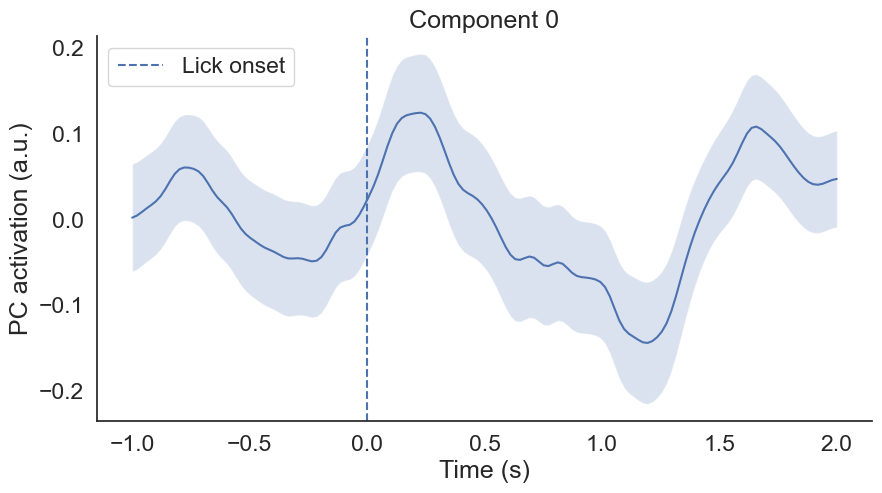

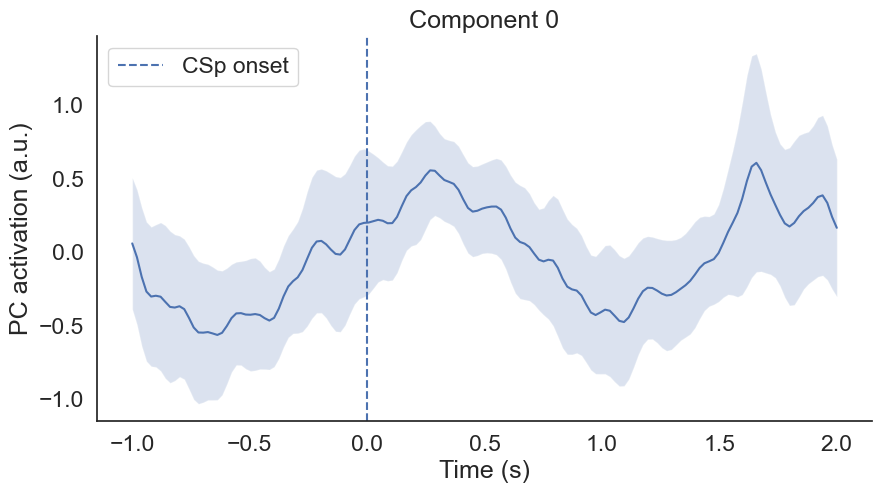

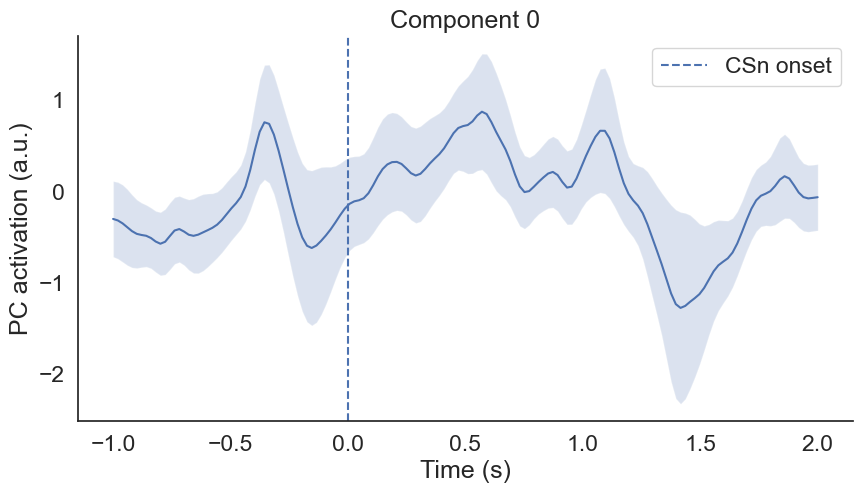

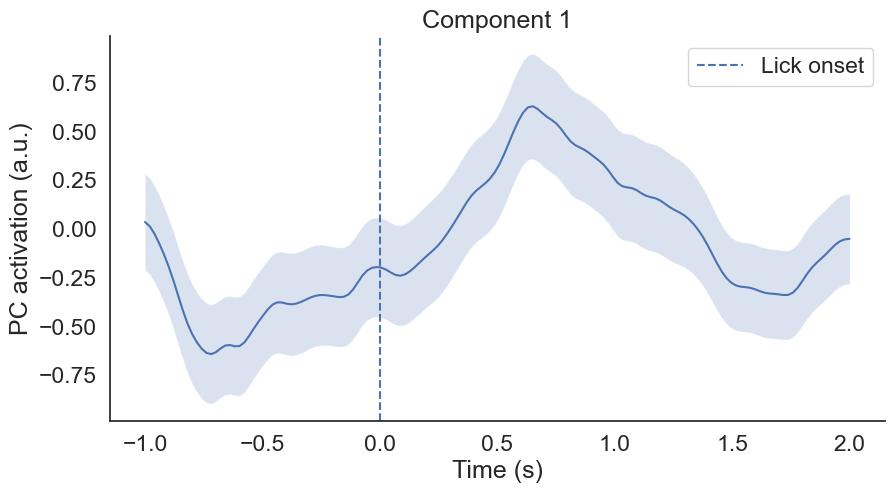

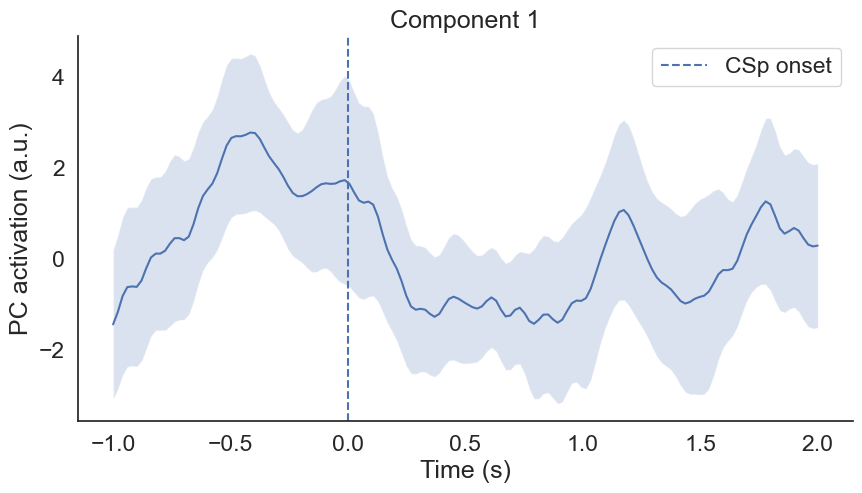

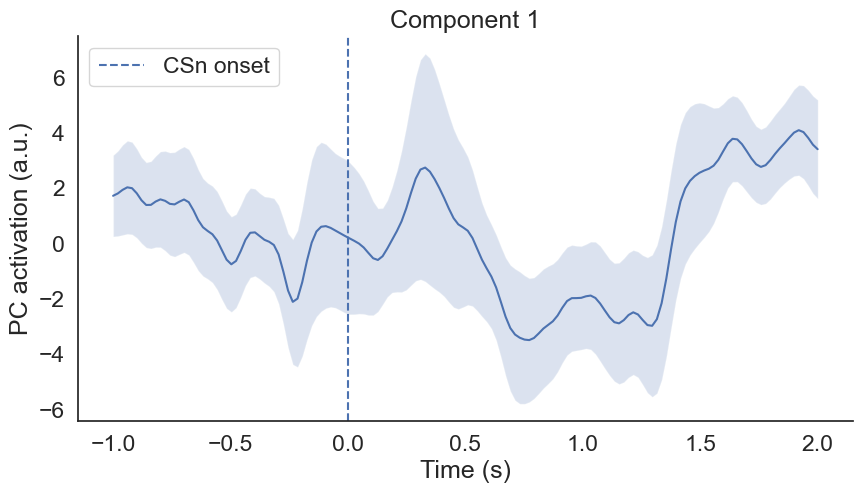

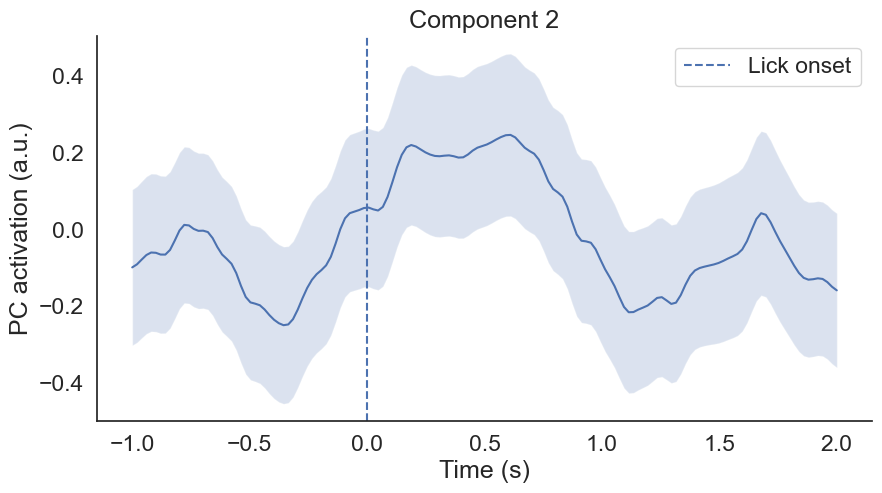

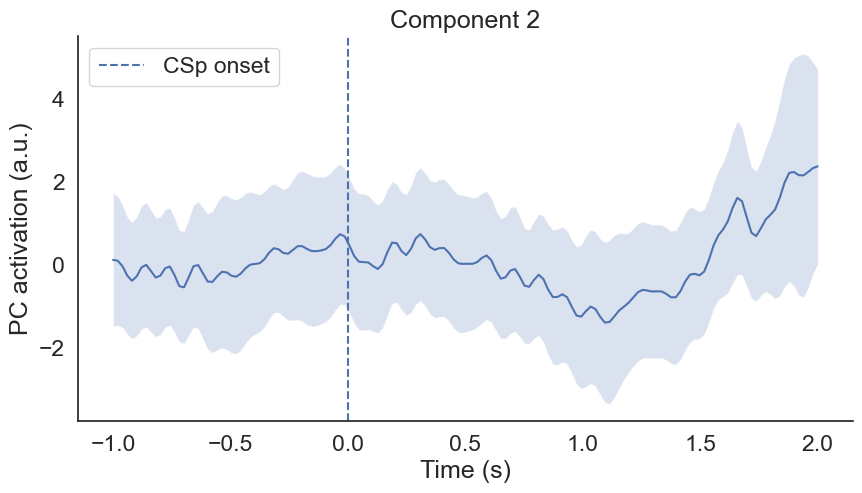

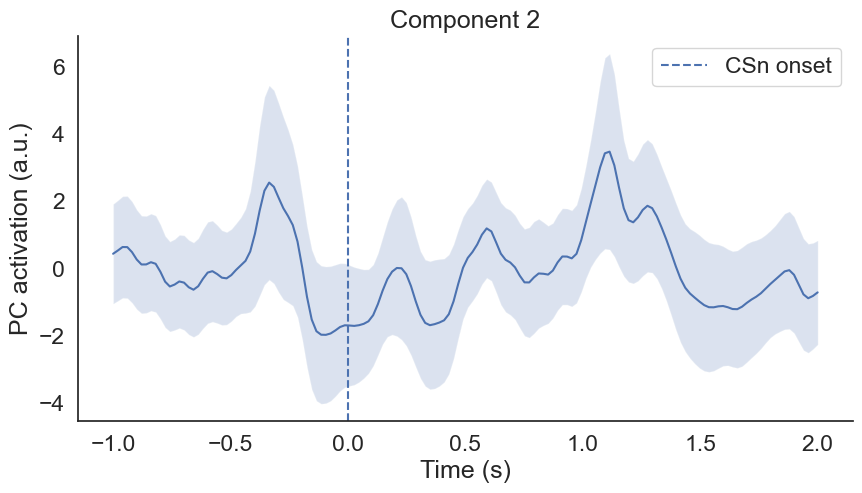

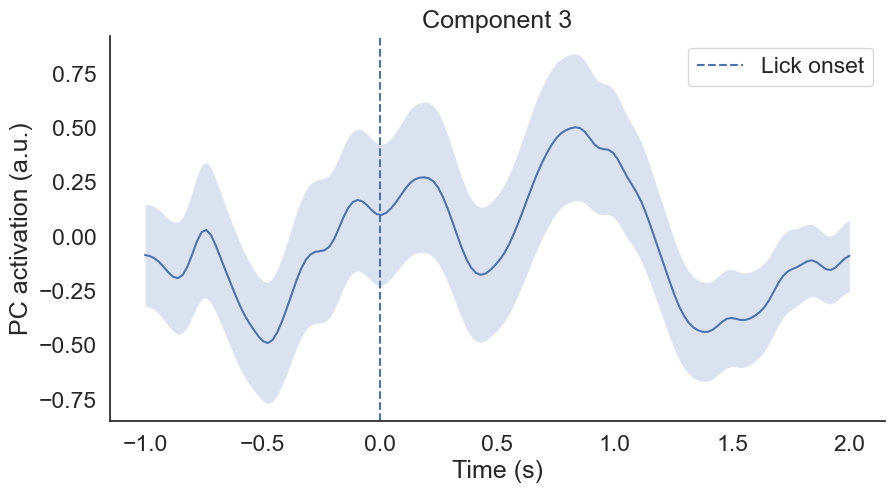

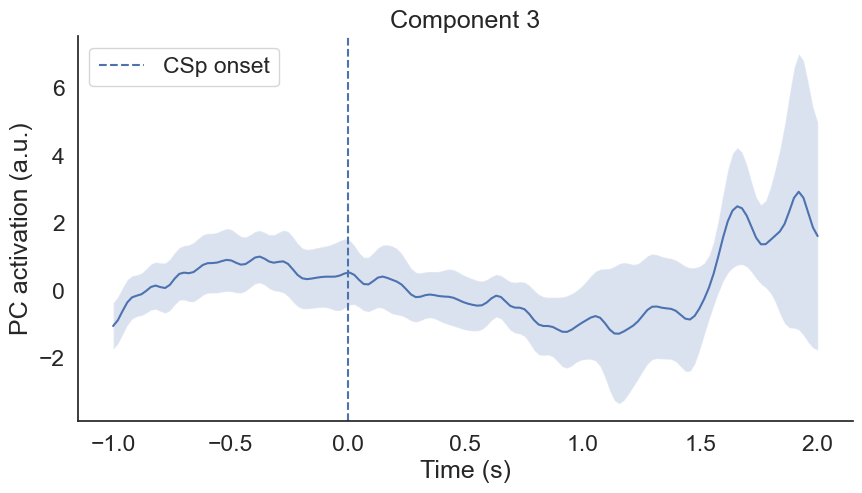

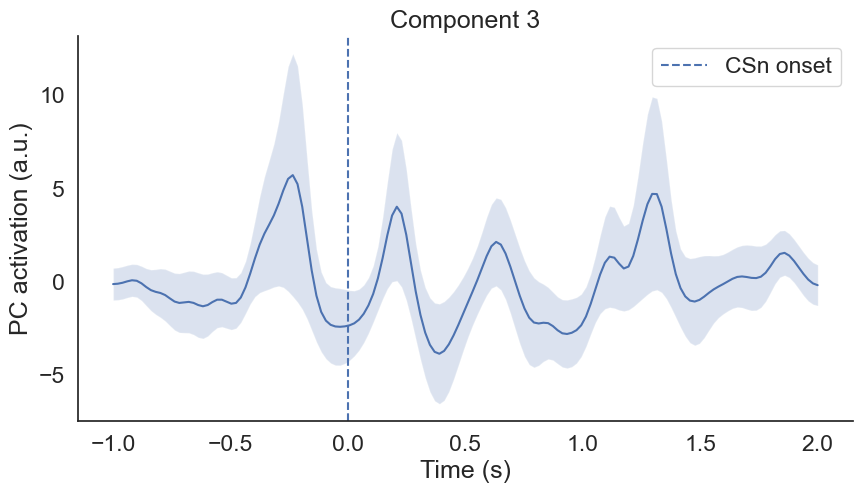

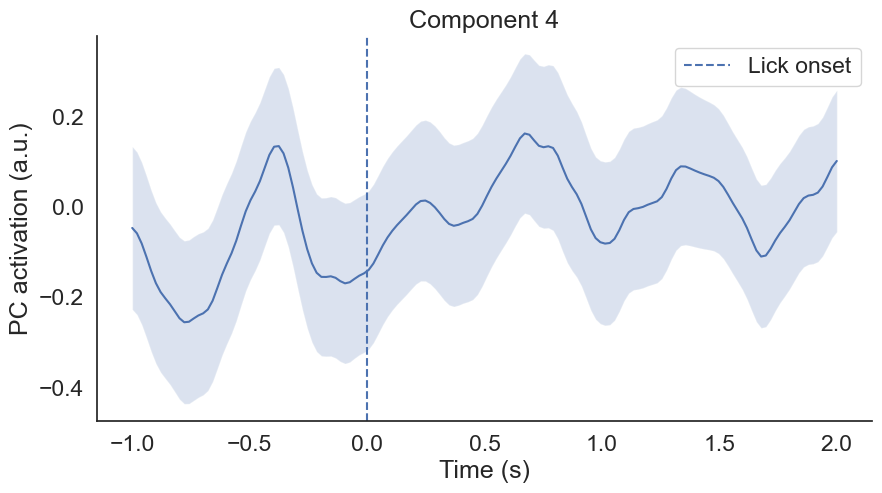

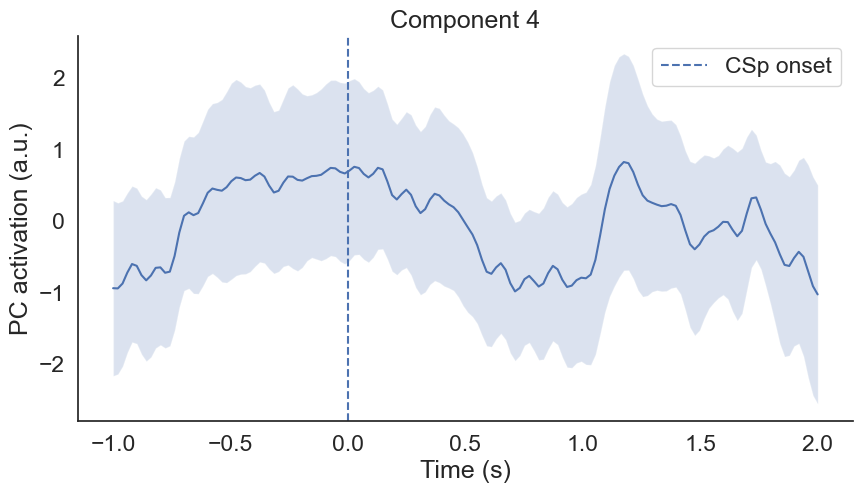

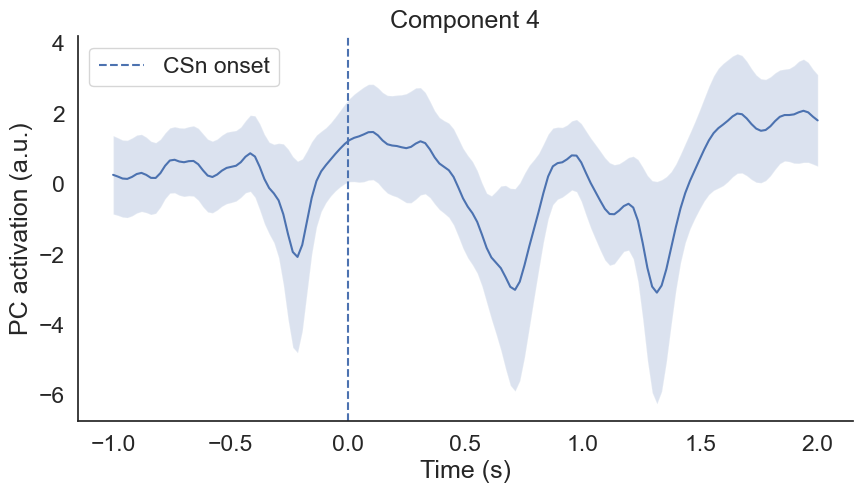

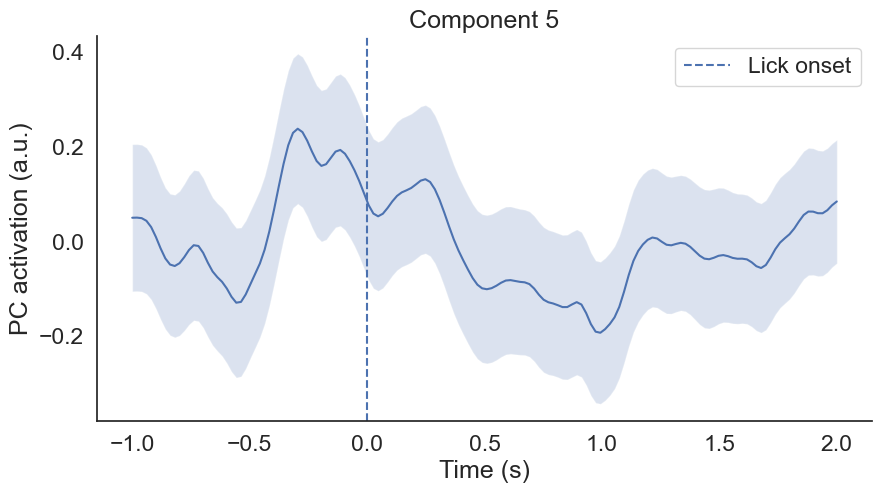

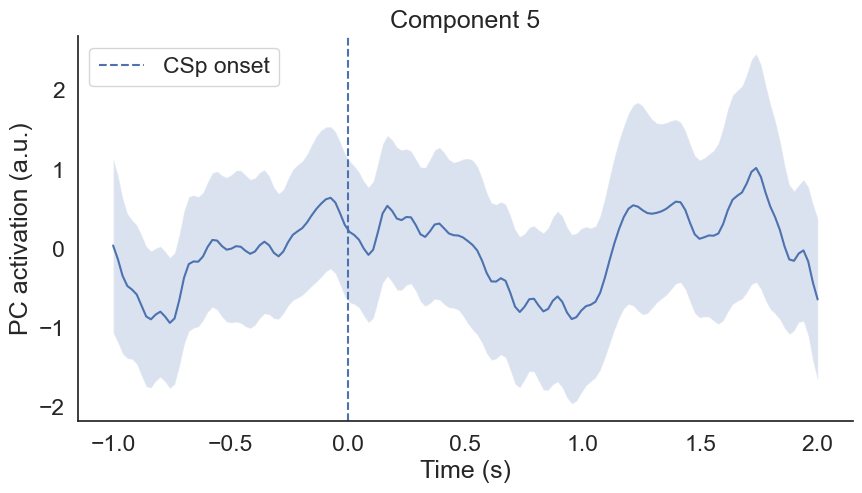

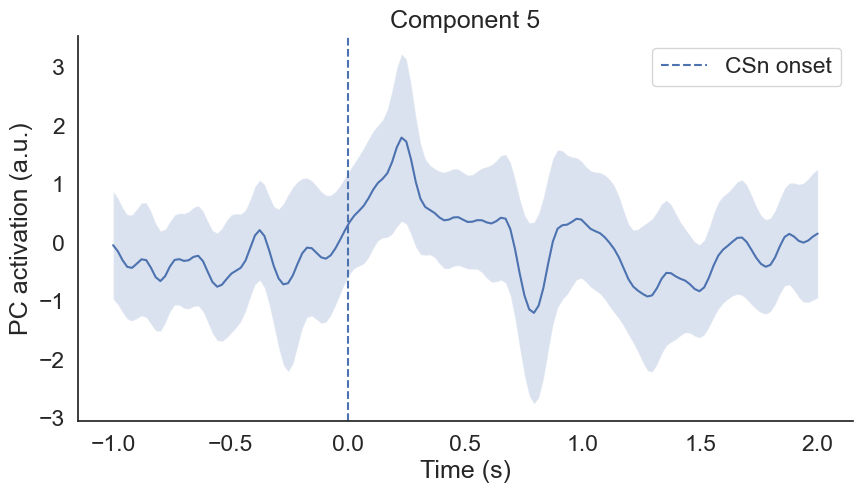

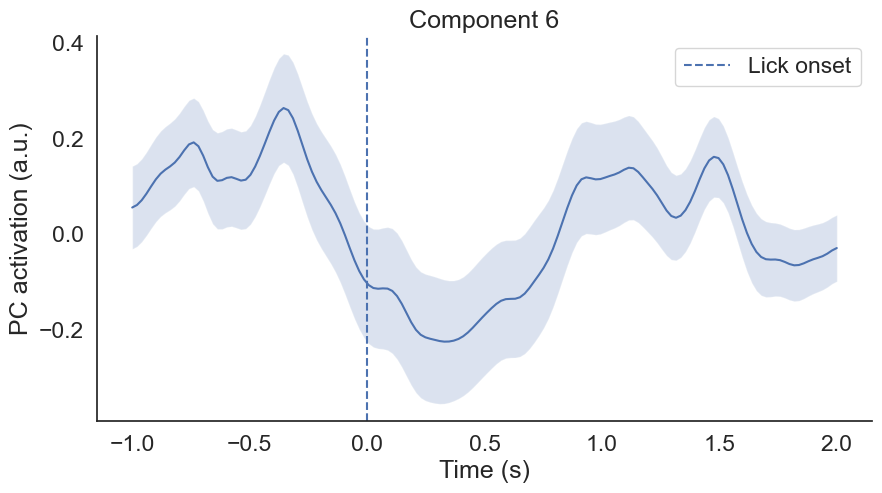

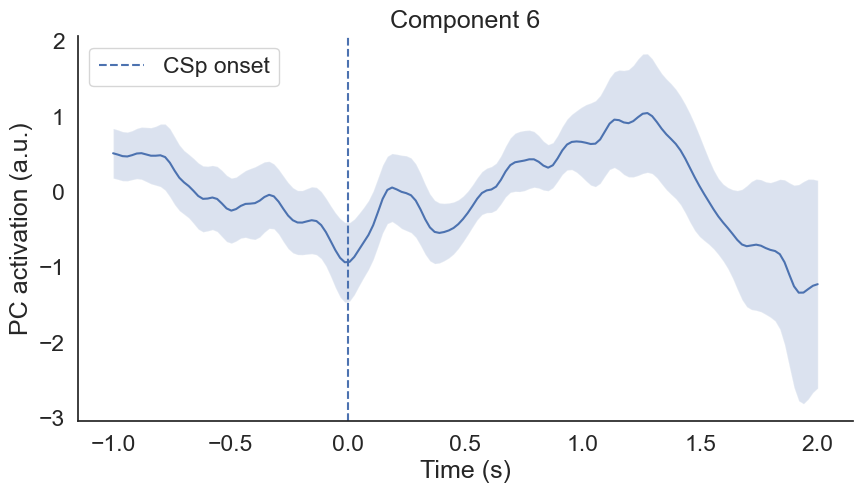

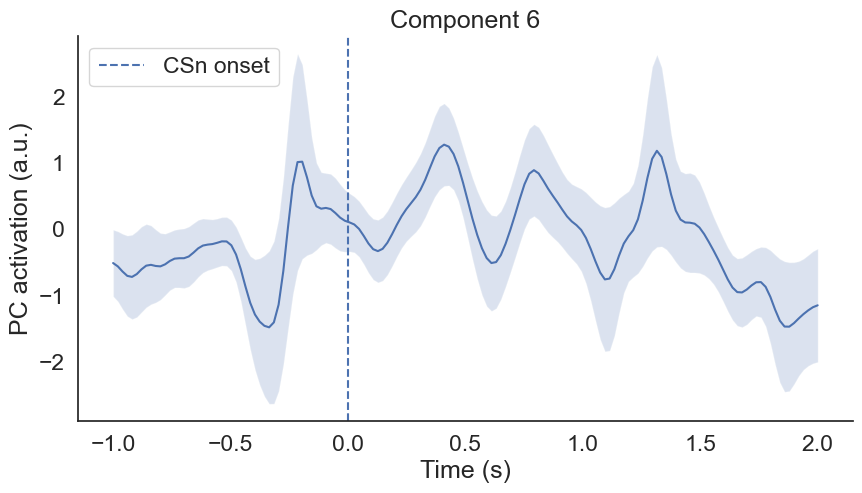

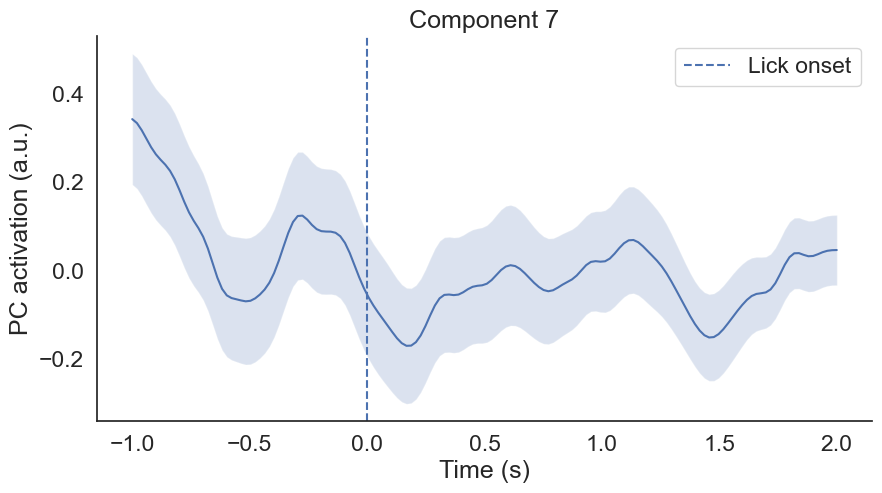

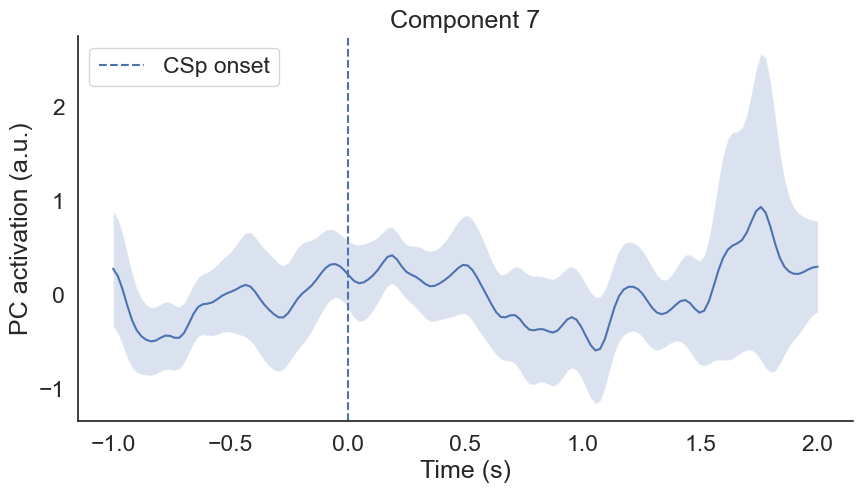

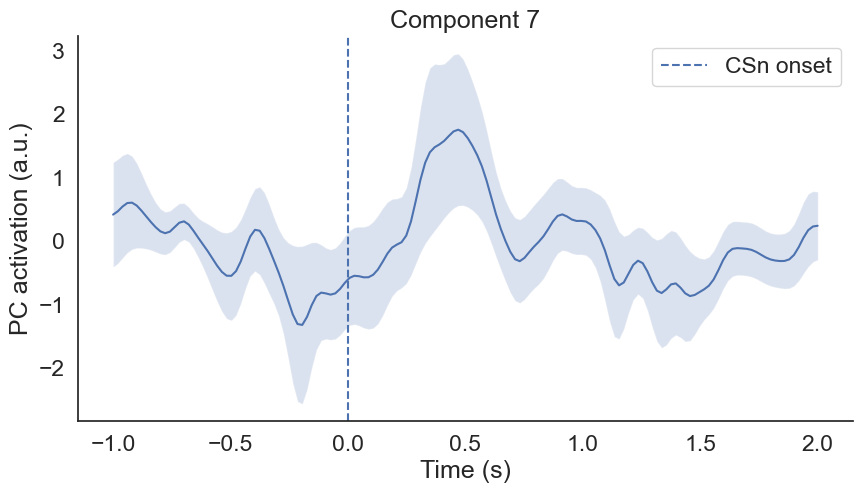

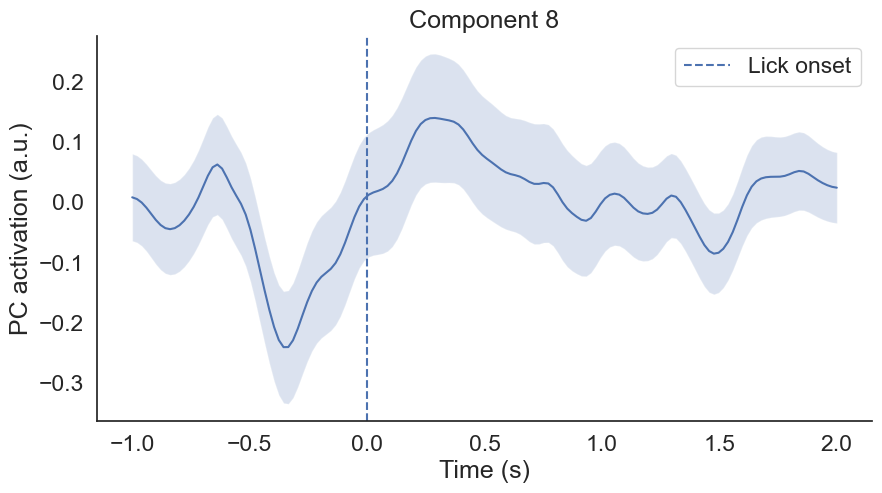

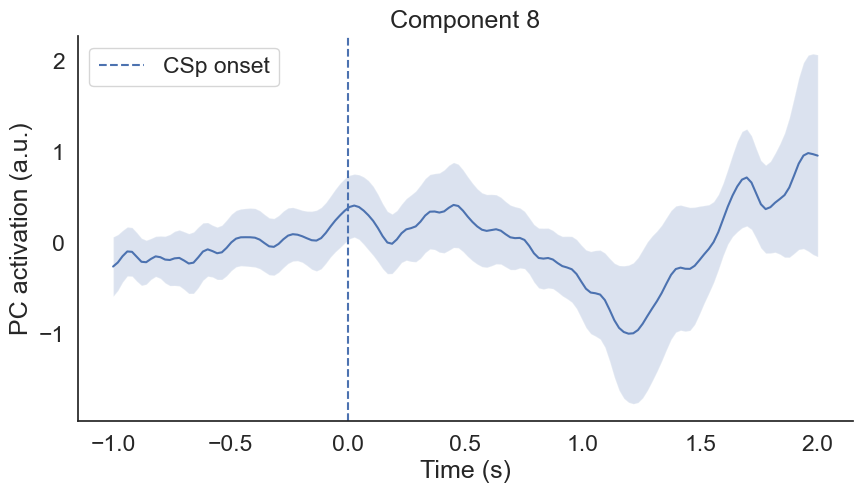

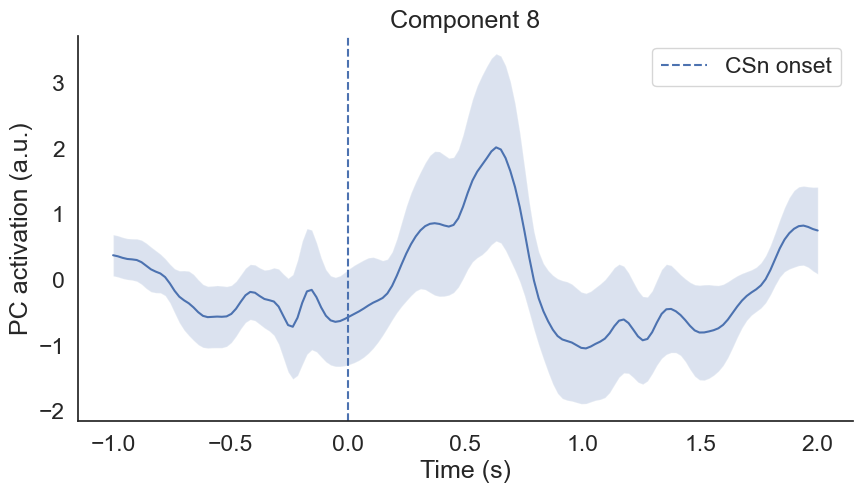

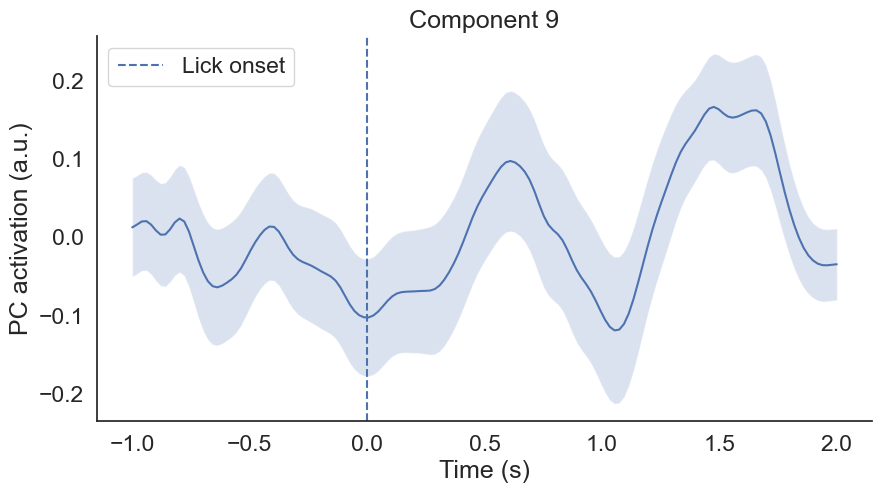

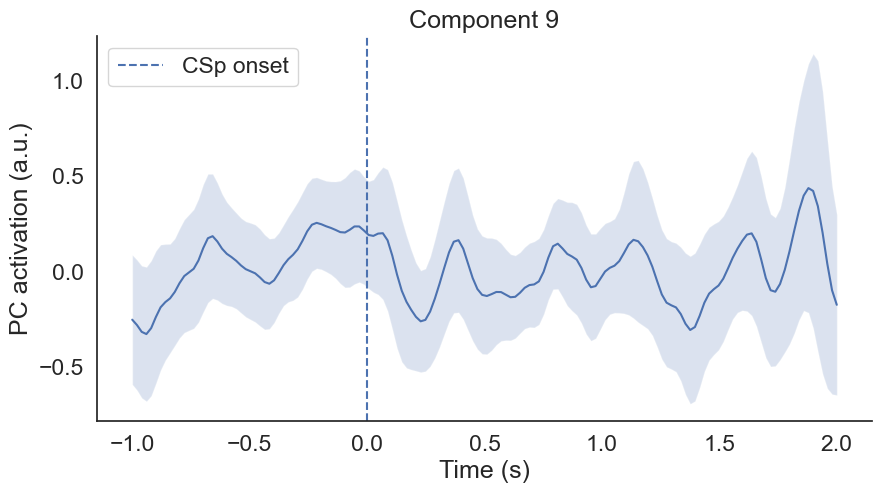

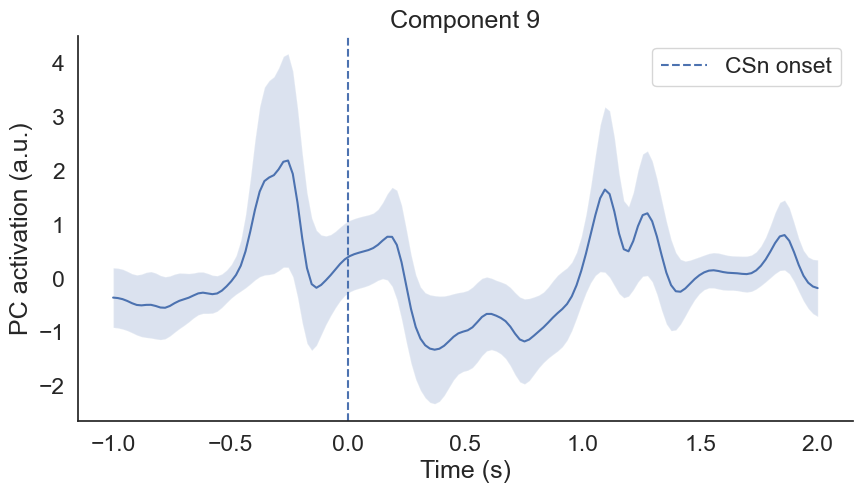

In [8]:
for comp in range(10):
    plot_around_event('Lick', comp = comp)
    plot_around_event('CSp', comp =  comp)
    plot_around_event('CSn', comp =  comp)



### Discussion
It seems that e.g. component 7 and 8 become active after a CSn onset, while I do not see clear correlations with CSp. Generally, lick and CSn might be correlated, since they have a strong overlap in the correlated components. This would need to investigated thoroughly.

To generally measure the statistical significance of observations and find new ones, it would make sense to compute the cross-correlation and Granger causality between the activation and the trains of events for the individual events. If we find a strong correlation/causality for some component and event, we could reshuffle the activation train n times and plot the result for correlation/causalit for the reshuffled event trains. If our original result would be a strong outlier, it would be fair to consider it significant.

## Exercise 3: nonlinear dimensionality reduction

Using the MNIST digit dataset, explore the effect of hyperparameters on the result of nonlinear dimensionality reduction methods.

- Change the `perplexity` and `exageration` parameters in `TNSE` (one at a time). Graphically compare the results of different values.
- Change the neighbourhood size in `Isomap` (set by the parameter `n_neighbors`), and visualize how the results change.

Finally, try to apply one or more of these methods to the cortical data we used in the lessons. How do the data look in two dimensions? Do any cluster seem to appear? Are they robust with respect to hyperparameter choice?

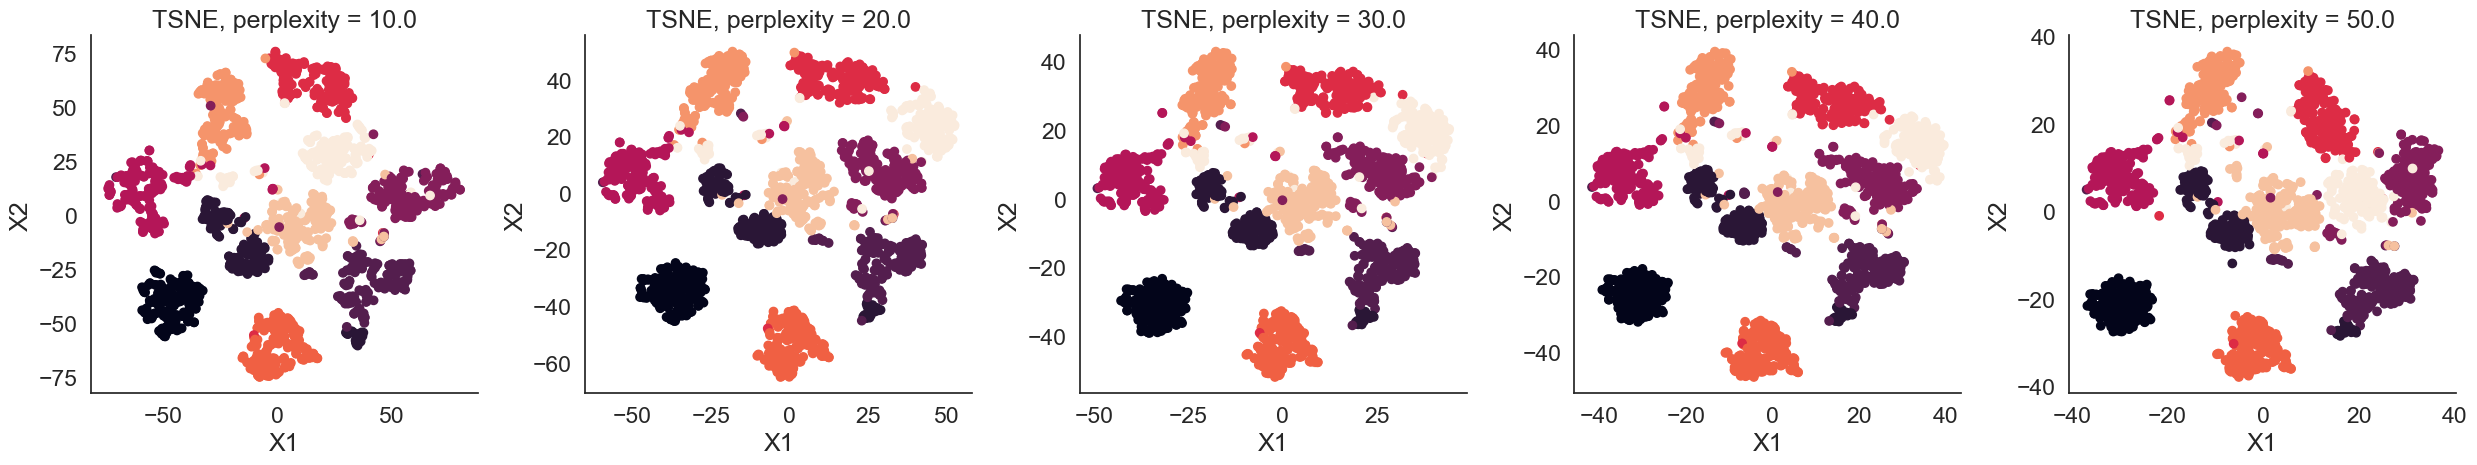

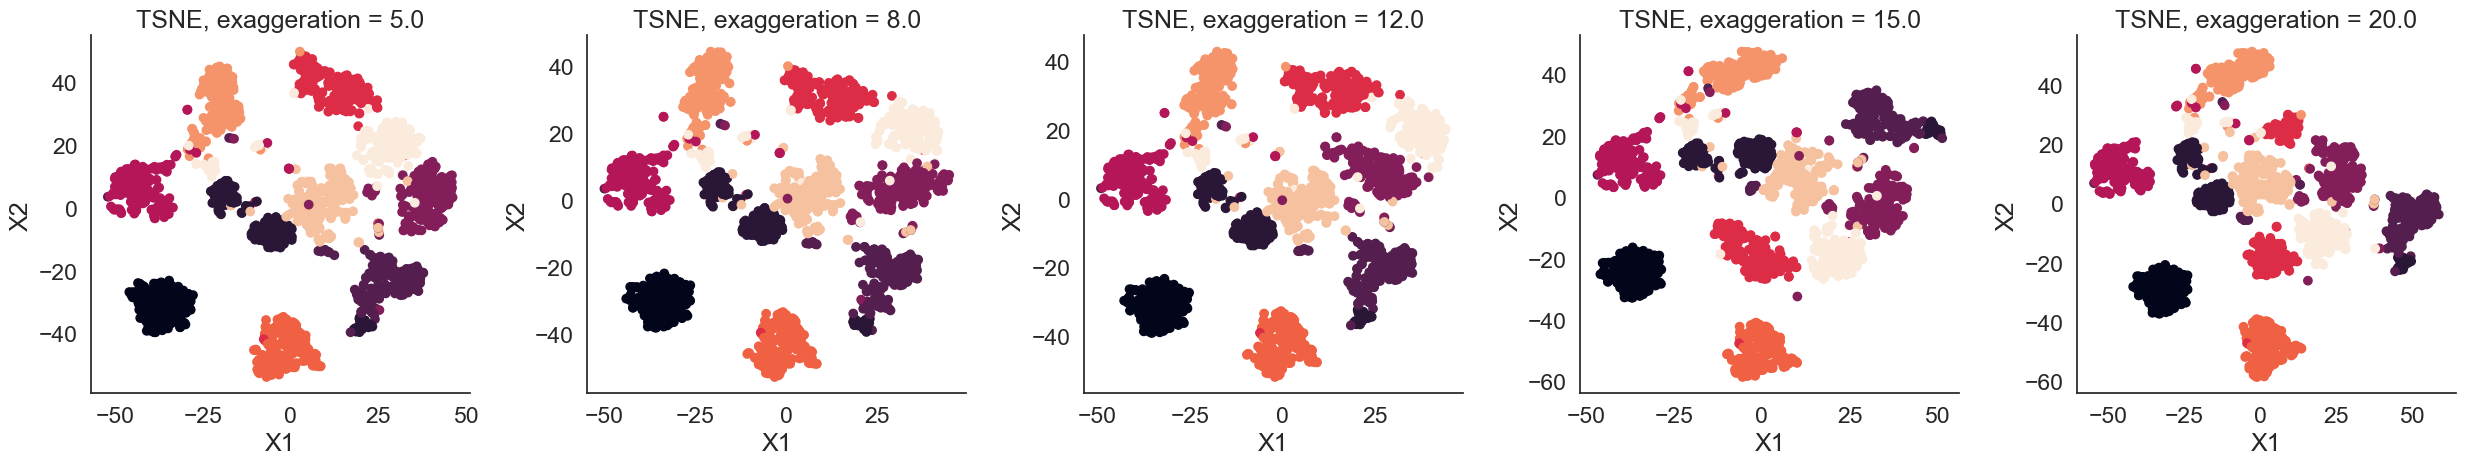

/opt/homebrew/Caskroom/miniconda/base/envs/neural_data/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/homebrew/Caskroom/miniconda/base/envs/neural_data/lib/python3.11/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/homebrew/Caskroom/miniconda/base/envs/neural_data/lib/python3.11/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/homebrew/Caskroom/miniconda/base/envs/neural_data/lib/python3.11/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyW

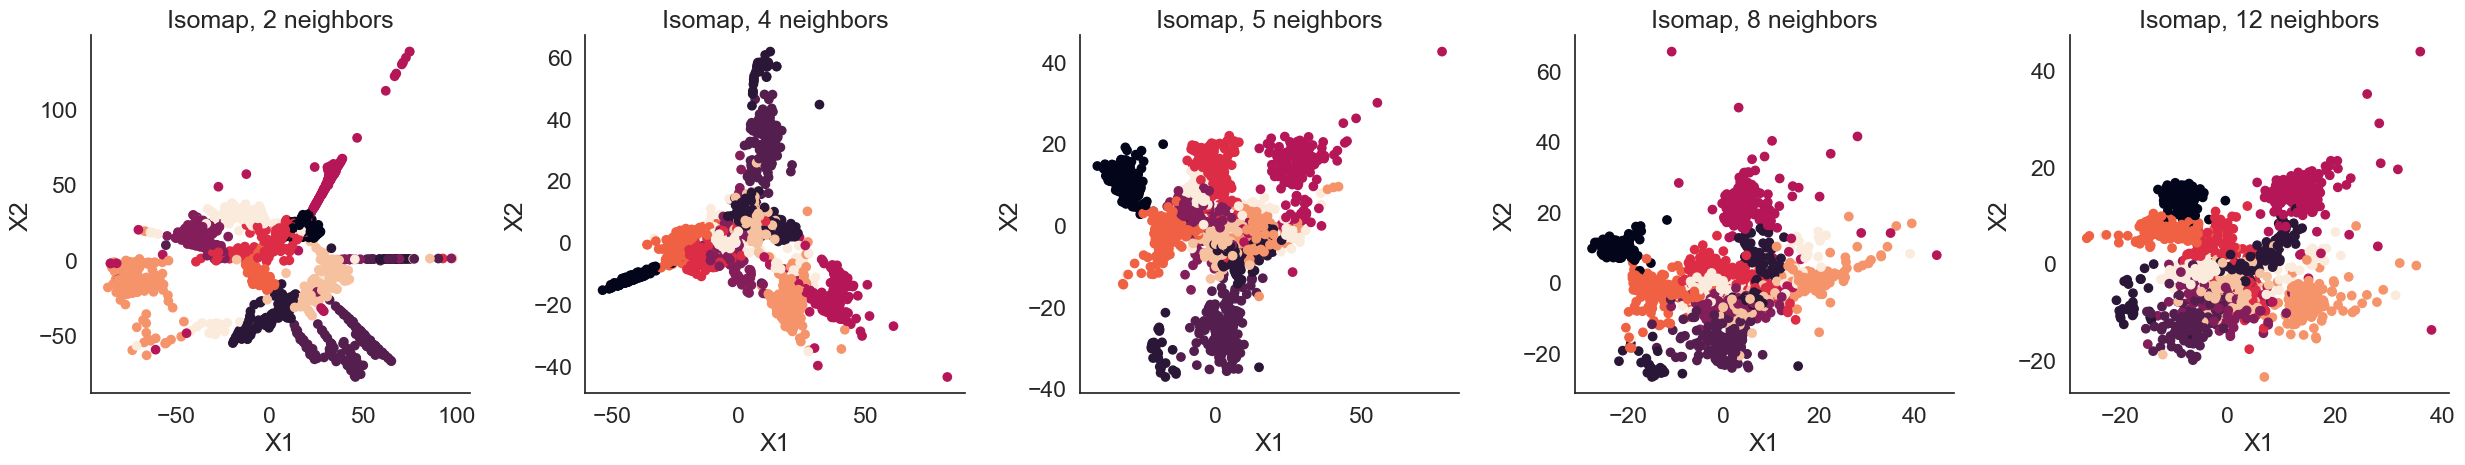

In [9]:
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

def plot_for_hyperparams(perplexities, exaggerations, n_neighbors):
    # load and preprocess data
    dataset = load_digits()
    images = dataset.data
    X = StandardScaler().fit_transform(images)
    plt.figure(figsize=(len(perplexities)*5,5))
    for n, perp in enumerate(perplexities):
        tsne = TSNE(n_components=2,random_state=0, perplexity = perp)
        X_tsne = tsne.fit_transform(X)
        
        
        plt.subplot(1,len(perplexities),n+1)
        plt.scatter(X_tsne[:,0],X_tsne[:,1],c=dataset.target)
        plt.title(f'TSNE, perplexity = {perp}')
        plt.xlabel('X1')
        plt.ylabel('X2')
    plt.tight_layout()
    
    plt.show()
    plt.figure(figsize=(len(exaggerations)*5,5))
    for n, ex in enumerate(exaggerations):
        tsne = TSNE(n_components=2,random_state=0, early_exaggeration = ex)
        X_tsne = tsne.fit_transform(X)
        
        
        plt.subplot(1,len(exaggerations),n+1)
        plt.scatter(X_tsne[:,0],X_tsne[:,1],c=dataset.target)
        plt.title(f'TSNE, exaggeration = {ex}')
        plt.xlabel('X1')
        plt.ylabel('X2')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(len(n_neighbors)*5,5))
    for n, n_neigh in enumerate(n_neighbors):
        isomap = Isomap(n_components=2, n_neighbors=n_neigh)
        X_iso = isomap.fit_transform(X)
        plt.subplot(1,len(n_neighbors),n+1)
        plt.scatter(X_iso[:,0],X_iso[:,1],c=dataset.target)
        plt.title(f'Isomap, {n_neigh} neighbors')
        plt.xlabel('X1')
        plt.ylabel('X2')
    plt.tight_layout()
    plt.show()

perplexities = [10., 20., 30., 40., 50.]
exaggerations = [5., 8., 12., 15., 20.]
n_neighbors = [2, 4, 5, 8, 12]
plot_for_hyperparams(perplexities, exaggerations, n_neighbors)

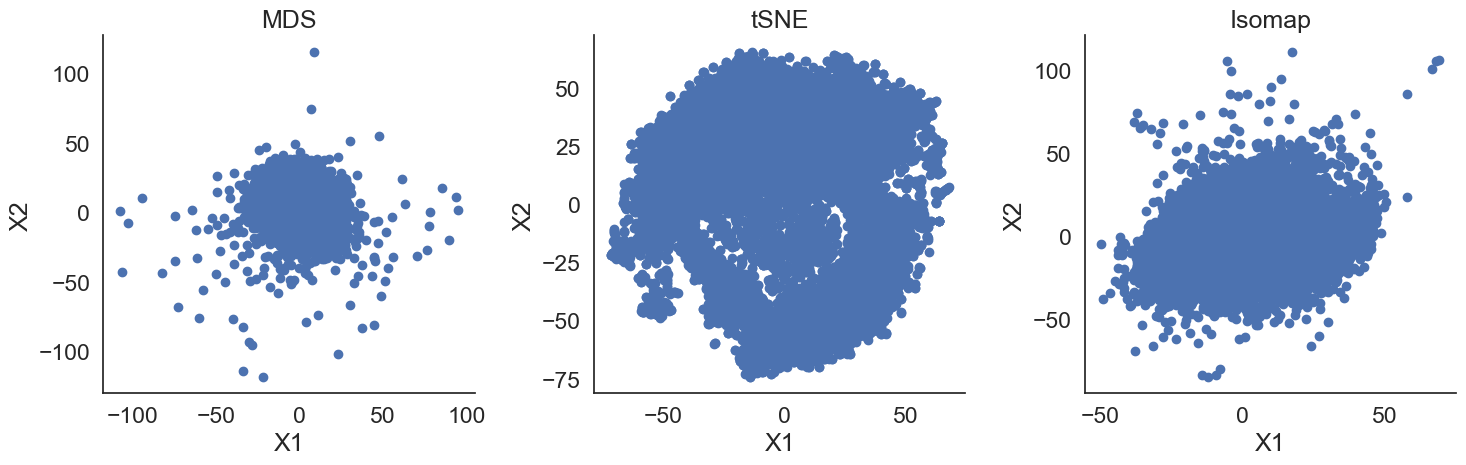

In [ ]:
with open('./data/behaviour.pickle', 'rb') as handle:
    trial_data = pickle.load(handle)

voltage_signal = np.load('./data/voltage_signal.npy')
cortex_mask = np.load('./data/cortex_mask.npy')

X = voltage_signal.transpose(2,0,1) # reshape in time x image format
T,h,w = X.shape # saves time, height and width for future use
X = X[:10000,cortex_mask] # select only cortex pixels, returns a flattened image

# initialize embedding calculator
mds = MDS(n_components=2,random_state=0,normalized_stress='auto')
tsne = TSNE(n_components=2,random_state=0)
isomap = Isomap(n_components=2)

#fit emebddings and transform data
X_mds = mds.fit_transform(X)
X_tsne = tsne.fit_transform(X)
X_iso = isomap.fit_transform(X)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(X_mds[:,0],X_mds[:,1])
plt.title('MDS')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,2)
plt.scatter(X_tsne[:,0],X_tsne[:,1])
plt.title('tSNE')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1,3,3)
plt.scatter(X_iso[:,0],X_iso[:,1])
plt.title('Isomap')
plt.xlabel('X1')
plt.ylabel('X2')

plt.tight_layout()

### Discussion
Because the kernel kept crashing, I only looked at the first 10000 time steps.

We can see no clear cluster in this for the first two components. However, this might behave differently for other components.

Changing the perplexity of the TSNE gives:

Text(0, 0.5, 'X2')

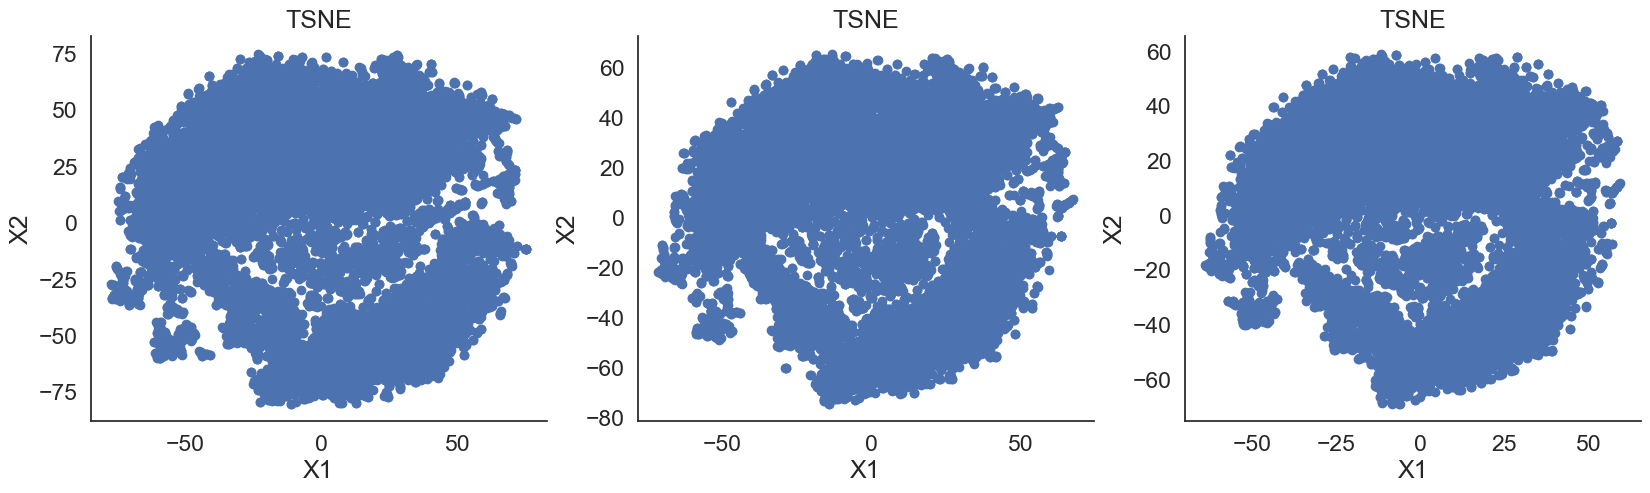

In [ ]:
tsne = TSNE(n_components=2,random_state=0, perplexity= 20)

#fit emebddings and transform data
X_tsne_20 = tsne.fit_transform(X)
tsne = TSNE(n_components=2,random_state=0, perplexity= 40)
X_tsne_40 = tsne.fit_transform(X)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(X_tsne_20[:,0],X_tsne_20[:,1])
plt.title('TSNE')
plt.xlabel('X1')
plt.ylabel('X2')
plt.subplot(1,3,2)
plt.scatter(X_tsne[:,0],X_tsne[:,1])
plt.title('TSNE')
plt.xlabel('X1')
plt.ylabel('X2')
plt.subplot(1,3,3)
plt.scatter(X_tsne_40[:,0],X_tsne_40[:,1])
plt.title('TSNE')
plt.xlabel('X1')
plt.ylabel('X2')



We can see that the method seems robust to perplexity changes. However, there is no obvious clustering visible either.